In [ ]:
%load_ext autoreload

In [ ]:
%autoreload 2

#### Requirements
- An AWS account
    - aws cli configured on the lcoal machine. [Instructions](https://docs.aws.amazon.com/cli/latest/userguide/cli-chap-configure.html)
- postgres db - Remote lazy way: [Lightsail](https://aws.amazon.com/lightsail/) is free for a month, easy to setup and teardown for experiments. postgress or mysql.
- Docker - [docker install](https://docs.docker.com/engine/install/#supported-platforms).  
- graphviz - [download](https://www.graphviz.org/download/).  Choose your os.
- python 3.7
    - prefect - `pip install -U "prefect[viz, aws]"` See [prefect install](https://docs.prefect.io/core/getting_started/installation.html) for other possibilities.

# Base Code

1. Extract from the TSX website a table with the imbalances
2. Preform an "expensive" transform
3. Load data to a db

### Requirements

In [1]:
import requests
import pandas as pd
import numpy as np
import sqlalchemy as sa

from prefect.client import Secret


import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)

# Use backup url for test
backup_url = "https://web.archive.org/web/20200414202757/https://api.tmxmoney.com/mocimbalance/en/TSX/moc.html"

### 1. Scrape the TSX MOC website. 
Data is only available weekdays after 15:40 pm Toronto time until 12 am.
Use archived url for testing.       
- https://web.archive.org/web/20200414202757/https://api.tmxmoney.com/mocimbalance/en/TSX/moc.html

In [2]:
def get_tsx_moc_imb(url: str):

    # 1, Get the html content
    html = requests.get(url).content
    
    # 2. Read all the tables
    df_list = pd.read_html(html, header=[0], na_values=[''], keep_default_na=False)
    
    tsx_imb_df = df_list[-1]
    
    logger.info(f"MOC download shape {tsx_imb_df.shape}")

    return tsx_imb_df

In [3]:
# Run the function to test
tsx_imb_df = get_tsx_moc_imb(backup_url)
print(f"Number of Symbols {tsx_imb_df.shape}")

tsx_imb_df.sample(n=4)

Number of Symbols (389, 4)


,Symbol,Imbalance Side,Imbalance Size,Imbalance Reference Price
167,MNT,BUY,100,27.000
82,DRT,BUY,14299,1.405
304,BPY.UN,SELL,32374,14.305
162,MDNA,BUY,100,3.570


In [6]:
df_lst = np.array_split(tsx_imb_df, 2)

In [8]:
df_lst[0]

,Symbol,Imbalance Side,Imbalance Size,Imbalance Reference Price
0,AAV,BUY,34003,1.725
1,ABX,BUY,460592,34.005
2,ACB,BUY,211790,1.035
3,AD,BUY,5204,9.575
4,ADN,BUY,100,13.215
...,...,...,...,...
190,OR,BUY,32006,11.800
191,OSB,BUY,3376,18.245
192,OSK,BUY,28502,3.375
193,OTEX,BUY,67355,52.105


### 2. Transform
- Rename some columns
- Add a column with imbalance side as  1, -1
- Calculate dollar delta

In [4]:
def add_imb_features(tsx_imb_df):
    # rename columns
    tsx_imb_df.rename(columns=lambda clm_nm: clm_nm.replace(" ", "_").lower(), inplace=True)
    
    # Convert the imbalance side to 1 and -1
    tsx_imb_df["imb_side_enc"] = np.where(tsx_imb_df['imbalance_side']=="BUY", 1, -1)

    return tsx_imb_df

In [7]:
# Run the transform

trans_df = add_imb_features(tsx_imb_df)
trans_df.sample(n=4)

,symbol,imbalance_side,imbalance_size,imbalance_reference_price,imb_side_enc
223,SII,BUY,34634,3.045,1
3,AD,BUY,5204,9.575,1
161,MDI,BUY,13621,3.595,1
382,VET,SELL,6539,5.945,-1


### 3. Load data to db
- The secret connection string is hosted it with the `prefect server` hosted by `prefect`. 
 - You can also [host your own server](https://medium.com/the-prefect-blog/open-sourcing-the-prefect-platform-d19a6d6f6dad)
- You can store your secrets using: 
  - `client.set_secret(name="my secret", value=42)`
 - Other possiilities include:env variables, `./prefect.config.toml` 
 - [Start here](https://docs.prefect.io/orchestration/concepts/secrets.html#setting-a-secret) [Core explanation](https://docs.prefect.io/api/latest/client/secrets.html#secret) 

In [ ]:
def df_to_db(df, tbl_name, conn_str):

    engine = sa.create_engine(conn_str)
    
    df.to_sql(
        name=tbl_name,
        con=engine,
        if_exists="append",
        index=True,
        method="multi"
        )
    
    engine.dispose()
  
    return df.shape

In [ ]:
conn_str = Secret("moc_pgdb_conn").get()
tbl_name = "moc_tst"

insert_shape = df_to_db(trans_df, tbl_name, conn_str)

### With the base code written it's time to configure the tasks.
In a more realistic development workflow tasks would be configured and added to a `Flow` incrementally.

## Configuration
This is done by adding the `@task` decorator to each of our functions with the configurations we need.  For a full list of options see [here](https://docs.prefect.io/api/latest/core/task.html#task)

The code above is starting to take shape and its time to take care of some error handling and our scraping constraints.
- For example:
    - Expensive to run tasks or any task that needs to be cached.  
    - result handling 

From here on: functions and classes are called `tasks`, Pipelines/Workflows/Scripts are `Flows`

In [ ]:
# New requirements
from datetime import timedelta

import prefect
from prefect import task

### 1.  Configuring the scrape function
`@task(...)`

Configurations - All of these are optional
- `max_retries`- Number of retries to handle a *failed [state](https://docs.prefect.io/api/latest/engine/state.html#state)*.

> State is the main currency in the Prefect platform. It is used to represent the current status of a flow or task

- `retry_delay` - How long to wait before a retry. `datetime.timedelta(...)`

- `result` - Where to save the task's result. (`LocalResult`, `S3Result`, [more](https://docs.prefect.io/api/latest/engine/results.html#result-subclasses)).  

- `target` - Cache results.  A string `tatget` .i.e. `"{task_name}-{today}"` that gets checked before the task is run. If the `target` string exists at the `result` location it will not be run.

>  cache tasks based on the presence of persisted data, such as a file on local disk or in cloud storage

 - Powerfull but dangerous if a develoer leaves an unintended `target`.

- `state_handlers` - How to handle the `task` behaviour as it moves between states. `Pending`, `Running`, `Success`, `Failed`, `Finished`.
 - There can be nultiple handlers for each task or the same handler for many tasks.
 - In our case the first task requires two:
     - `imb_handler` Sets a state to `is_failed` when extractng an empty dataframe from the TSX. This happens if the data is scraped before 15:40 and after 24:00 EST or no MOC was published to the website. (Used only in this task)
     - `error_handler` - Handle all the unhandled exceptions. It raises a `SKIP` `signal` when any of the tasks fails.  This ensures that any tasks in our flow will not run if the upstream task failed.  The default configuration in `task` is `skip_on_upstream_skip=True`.

### State Handlers

Additional requirement

In [ ]:
from prefect.engine.state import Success, Failed, Skipped
from prefect.engine import signals
from prefect.engine.results import S3Result, LocalResult

In [ ]:
@task(
    max_retries=3,
    retry_delay=timedelta(seconds=1), # In production this will be change to 20 minutes
    target="{task_name}-{today}.prefect",
    result=tsx_imb_res, # S3Result(bucket="tsx-moc-bcp/{task_name}-{today}"), 
    state_handlers=[imb_handler, error_handler]
)
def get_tsx_moc_imb(url: str):
    
    # Pefect logger added.  See https://docs.prefect.io/core/idioms/logging.html#logging-from-within-tasks
    #logger = prefect.context.get("logger") # (Error: jupyter notebook?)
    
    #raise Exception
    
    # 1, Get the html content
    html = requests.get(url).content
    
    # 2. Read all the tables
    df_list = pd.read_html(html, header=[0], na_values=[''], keep_default_na=False)
    
    tsx_imb_df = df_list[-1]
    
    logger.info(f"MOC download shape {tsx_imb_df.shape}")

    return tsx_imb_df

- To run the the function `.run` is used.  
- None of the configurations take hold until we orchastrate the tasks.

In [ ]:
# Run the function to test
tsx_imb_df = get_tsx_moc_imb.run(backup_url)
print(f"Number of Symbols {tsx_imb_df.shape}")

tsx_imb_df.sample(n=4)

### Testing the first `task` in a `Flow`

At the most basic level a [`Flow`](https://docs.prefect.io/api/latest/core/flow.html#flow-2) is where the realtionship betwee tasks is defined. 

> The Flow class is used as the representation of a collection of dependent Tasks. Flows track Task dependencies, parameters and provide the main API for constructing and managing workflows.


Like a `task` they have their own configuration. (Partial List)
- `name` - The name of the flow. (Required, all the others are optionsl)
- `schedule` - A scheduled time to run the flow. (big difference between Airflow and prefect)
- `storage` - `Local`, `Docker`, `s3`, [more](https://docs.prefect.io/orchestration/execution/storage_options.html#storage-options)

> Storage objects provide a way to save and retrieve Flows...

    Useful for deployment or when using prefect server along with an [`Agent`](https://docs.prefect.io/orchestration/agents/overview.html) to monitor  and restart `Flows`.
- `environment` - How and where to `run` the `Flow`.

> ... how your Flow should be run e.g., which executor to and whether there are any auxiliary infrastructure requirements for your Flow's *execution*.  if you want to run your Flow on Kubernetes using an auto-scaling Dask cluster then you're going to want to use an environment for that!

   - The [`executor`](https://docs.prefect.io/api/latest/engine/executors.html#executor), (`LocalExecutor`, `LocalDaskExecutor`, `DaskExecutor`) can be set within the `enviroment` keyword argument or the  Flow's keyword argument.
   
   > Prefect Executors implement the logic for how Tasks are run
  
   
- In this example `storage` and `enviroment` are local so no configuration is needed.

Finally Flows accept [`Parameters`](https://docs.prefect.io/core/concepts/parameters.html#parameters)

> Parameters are special tasks that can receive user inputs whenever a flow is run. Setting a default is optional.

Additional requirement

In [ ]:
from prefect import Flow, Parameter
from prefect.engine.results import S3Result

In [ ]:
with Flow("Our first flow") as tst_flow:
    
    tsx_url = Parameter("tsx_url", default="https://api.tmxmoney.com/mocimbalance/en/TSX/moc.html")
    
    tsx_imb_df = get_tsx_moc_imb(tsx_url)

Before running the flow can be visualized.
- Optional [`visualize` arguments](https://docs.prefect.io/api/latest/core/flow.html#flow-2).  At the bottom of the page

In [ ]:
tst_flow.visualize()

### Running the Flow

- Like `task`, the `Flow` is executed using the `run` method.
- As the flow is running the `prefect logger` output the `state` of the `task` in the flow. ` Success`, `Failed`, ` Skipped`. This is useful for debugging.
- If a `Flow` is run with a dask executor the order of execution is not insured other than binded tasks/nodes.
- Post `run` the `Flow` can be visualized by capturing its states
 - `tst_flow.visualize(flow_state=<fl_states>)`
  - 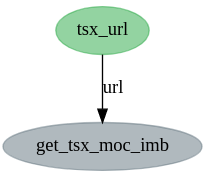
 - By *registeriing* the `Flow` with `prefect server`  ([managed](https://www.prefect.io/pricing), [open source](https://docs.prefect.io/orchestration/tutorial/configure.html#spin-up-prefect-core-s-server)) and initializing an [`Agent`](https://docs.prefect.io/orchestration/agents/overview.html) additional analytics are available. 
 
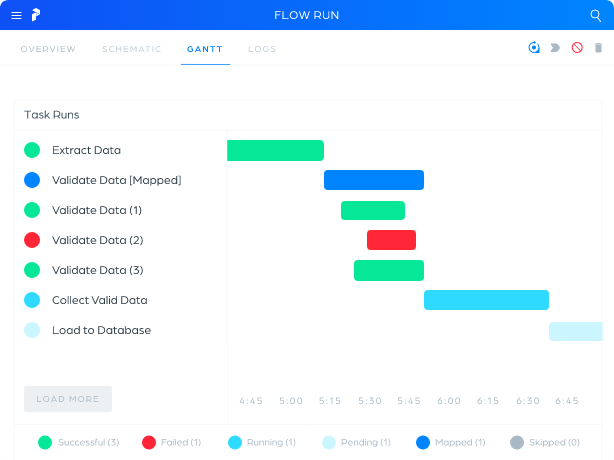

In [8]:
fl_states = tst_flow.run(
    parameters={"tsx_url":backup_url}
)

NameError: name 'tst_flow' is not defined

In [ ]:
# Initialize where to store task results
#tsx_imb_res = S3Result(bucket="tsx-moc-bcp")
tsx_imb_res = LocalResult(dir="~/MOC/moc_res")
def error_handler(obj, old_state, new_state):
    
    if new_state.is_failed():
        # # Sends a slack notification to system errors in the tapnotion slack channel
        #         s = Secret("system_errors") # create a secret object
        #         slack_web_hook_url = s.get() # retrieve its value

        #         msg = f"Task '{obj.name}' finished in state {new_state.message}"
        # replace URL with your Slack webhook URL
        # requests.post(slack_web_hook_url, json={"text": msg})
        
        raise signals.SKIP(message='skipping!')
        return_state = Failed("Failed")
                              
        
    else:
        return_state = new_state   
        
    return return_state

def imb_handler(obj, old_state, new_state):
    # Hamdle an empty dataframe to return a fail message.  
    # The result of a succesfull 
    if isinstance(new_state, Success) and new_state.result.empty:
        return_state = Failed(
            message=f"No tsx imbalance data: No trading or Data was not published to {new_state.cached_inputs['url']}", 
            result=new_state.result
            )        
    else:
        return_state = new_state   

    return return_state

In [ ]:
tst_flow.visualize(flow_state=fl_states)

# Putting it all together
- All three tasks configured in a flow with local execution

In [16]:
from prefect.engine.results import LocalResult, S3Result
s3_result = S3Result(bucket='tsx-moc-bcp')
df_result = s3_result.read(location='2020/5/19/e0d783db-e94f-4f1f-a2c9-c688b7c1742d.prefect_result')
df= df_result.value
df

[       Imbalance Side  Imbalance Size  Imbalance Reference Price
 Symbol                                                          
 AAV               BUY           34003                      1.725
 ABX               BUY          460592                     34.005
 ACB               BUY          211790                      1.035
 AD                BUY            5204                      9.575
 ADN               BUY             100                     13.215
 ...               ...             ...                        ...
 EMP.A             BUY           74741                     29.230
 ENGH              BUY            6117                     50.190
 EQB               BUY            3551                     61.680
 EQX               BUY           15987                     10.695
 ERF               BUY           13546                      2.785
 
 [98 rows x 3 columns],
        Imbalance Side  Imbalance Size  Imbalance Reference Price
 Symbol                                           

In [12]:
df

(97, 3)

In [ ]:
import requests
import pandas as pd
import numpy as np
import sqlalchemy as sa

from prefect.client import Secret


import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)

backup_url = "https://web.archive.org/web/20200414202757/https://api.tmxmoney.com/mocimbalance/en/TSX/moc.html"

In [ ]:
fl_states = tst_flow.run(
    parameters={"tsx_url":backup_url}
)

tst_flow.visualize(flow_state=fl_states)

### Configuration Validation 

In [ ]:
# Initialize where to store task results
#tsx_imb_res = S3Result(bucket="tsx-moc-bcp")
tsx_imb_res = LocalResult(dir="~/MOC/moc_res")
def error_handler(obj, old_state, new_state):
    
    if new_state.is_failed():
        # # Sends a slack notification to system errors in the tapnotion slack channel
        #         s = Secret("system_errors") # create a secret object
        #         slack_web_hook_url = s.get() # retrieve its value

        #         msg = f"Task '{obj.name}' finished in state {new_state.message}"
        # replace URL with your Slack webhook URL
        # requests.post(slack_web_hook_url, json={"text": msg})
        
        raise signals.SKIP(message='skipping!')
        return_state = Failed("Failed")
                              
        
    else:
        return_state = new_state   
        
    return return_state

def imb_handler(obj, old_state, new_state):
    # Hamdle an empty dataframe to return a fail message.  
    # The result of a succesfull 
    if isinstance(new_state, Success) and new_state.result.empty:
        return_state = Failed(
            message=f"No tsx imbalance data: No trading or Data was not published to {new_state.cached_inputs['url']}", 
            result=new_state.result
            )        
    else:
        return_state = new_state   

    return return_state





@task(
    max_retries=3,
    retry_delay=timedelta(seconds=1), # In production this will be change to 20 minutes
    target="{task_name}-{today}.prefect",
    result=tsx_imb_res, # S3Result(bucket="tsx-moc-bcp/{task_name}-{today}"), 
    state_handlers=[imb_handler, error_handler]
)
def get_tsx_moc_imb(url: str):
    
    # Pefect logger added.  See https://docs.prefect.io/core/idioms/logging.html#logging-from-within-tasks
    #logger = prefect.context.get("logger") # (Error: jupyter notebook?)
    
    raise 1/0
    
    # 1, Get the html content
    html = requests.get(url).content
    
    # 2. Read all the tables
    df_list = pd.read_html(html, header=[0], na_values=[''], keep_default_na=False)
    
    tsx_imb_df = df_list[-1]
    
    logger.info(f"MOC download shape {tsx_imb_df.shape}")

    return tsx_imb_df

@task
def add_imb_features(tsx_imb_df):
    # rename columns
    tsx_imb_df.rename(columns=lambda clm_nm: clm_nm.replace(" ", "_").lower(), inplace=True)
    
    # Convert string to
    tsx_imb_df["imb_side_enc"] = np.where(tsx_imb_df['imbalance_side']=="BUY", 1, 0)

    return tsx_imb_df




### Rerun the flow

In [ ]:
with Flow("Our first flow") as tst_flow:
    
    tsx_url = Parameter("tsx_url", default="https://api.tmxmoney.com/mocimbalance/en/TSX/moc.html")
    
    tsx_imb_df = get_tsx_moc_imb(tsx_url)

In [ ]:
fl_states = tst_flow.run(
    parameters={"tsx_url":backup_url}
)
tst_flow.visualize(flow_state=fl_states)

Prefect is not limited to the number of tasks. Even shell script can be a task. As such complex transformations can be used from other languages simply by calling the shell as a task

## What is nice about this?
### - Flows and task logic can be examined. 
### -  Pipeline requirements are explicit.
 - Making requirements and implementation decisions well understood to maintainer(s).
 
### - The pipeline can scale with the development workflow. 

In [ ]:
tsx_url = 'https://api.tmxmoney.com/mocimbalance/en/TSX/moc.html'
backup_url = "https://web.archive.org/web/20200414202757/https://api.tmxmoney.com/mocimbalance/en/TSX/moc.html"

tsx_imb_df = get_tsx_moc_imb(backup_url)
print(tsx_imb_df.shape)
tsx_imb_df.head(3)  

### b. Load to database

This task takes the transformed data as an input and loads the `imb_df` to a database using `sqlAlchemy`.  There are many ways to accomplish this goal, including some baked into `prefect`. But this is the simplest in terms of writing from a small `df`. 

In [ ]:
import sqlalchemy as sa
def df_to_db(df, tbl_name, conn_str):

    engine = sa.create_engine(conn_str)
    
    df.to_sql(
        name=tbl_name,
        con=engine,
        if_exists="replace",
        index=True,
        method="multi",
        chunksize=5000
        )
    
    engine.dispose()
  
    return df.shape

Build a connection string using your own credentials for the db

Run the function.  A new table with the imb data should now be inserted

In [ ]:
from prefect.client import Secret

conn_str = Secret("moc_pgdb_conn").get()

In [ ]:
df_shape = df_to_db(tsx_imb_df, tbl_name="moc_tst", conn_str=conn_str)
df_shape

## Stage 2 - Configuration and Orchestration for production

Next we set up the `prefect` config to set:.  
- `checkpointing` to True when a `Result handler` is given as a keyword argument. 
- `cloud.secrets` to True  this way the secrets stored  on prefect cloud to be called
    - Secrets can also be used locally with enviroment variables see link

Setting up the prefect config for deployment: 

1. In the terminal go to the prefect directory

    cd ~
    
    cd .prefect
2. Check if a config exists

    ls

    

    If it does not exist:
    
    touch config.toml

3. Open the file.

    nano config.toml

4. Get a cloud token from prefect

5. Add the following configuration.  [prefect config](https://docs.prefect.io/core/concepts/configuration.html)
  
 
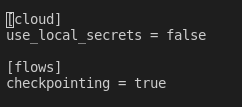

6. quit nano

### Configuring the `get_tsx_moc_imb` to handle retries and saving its result to `s3`.

In the code below an @task decorator was added with four configurations to handle some possiple errors.  Furthermore the LocalResultHandler, S3ResultHandler were importedto write the tasks results to a location specified.  If a directory is not specified in the localhandler, the result is located in ~.prefect/results

for all the possible keyword configurations see [`Tasks`](https://docs.prefect.io/api/latest/core/task.html#task-2)

In addition a state handler was added to handle the state of our `task` .  The state handler handles the definition of the state Success, In progress, pending Failure.  This is where the empty dataframe is handled.  There is no reason to for the `write to db` task to attempt running if there is an empty dataframe. 

In [ ]:
import sqlalchemy as sa
import pandas as pd
import requests

from datetime import timedelta

from prefect import task
from prefect.engine.result_handlers import LocalResultHandler, S3ResultHandler

import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)

s3_handler = S3ResultHandler(bucket='tsx-moc-bcp')  
lcl_handler = LocalResultHandler()

def my_state_handler(obj, old_state, new_state):
    msg = "\nCalling my custom state handler on {0}:\n{1} to {2}\n"
    print(msg.format(obj, old_state, new_state))
    return new_state

@task(
    max_retries=2, 
    retry_delay=timedelta(seconds=1),
    result_handler=s3_handler)
    #state_handlers=[])
def get_tsx_moc_imb(url: str):
    """
    Scrape the TSX website Market on close website. Data only available weekdays after 15:40 pm Toronto time
    until 12 am.
    
    Use archived url for testing.       
    "https://web.archive.org/web/20200414202757/https://api.tmxmoney.com/mocimbalance/en/TSX/moc.html"
    """
    # assert 1/0
    
    # 1, Get the html content
    html = requests.get(url).content
    
    # 2. Read all the tables
    df_list = pd.read_html(html, header=[0], na_values=[''], keep_default_na=False)
    
    tsx_imb_df = df_list[-1]
    
    logger.info(f"MOC download shape {tsx_imb_df.shape}")

    return tsx_imb_df

@task
def get_yahoo_data(df):
    return df


@task
def df_to_db(df, tbl_name, conn_str):

    engine = sa.create_engine(conn_str)
    
    df.to_sql(
        name=tbl_name,
        con=engine,
        if_exists="replace",
        index=True,
        method="multi",
        chunksize=5000
        )
    
    engine.dispose()
  
    return df.shape

In [ ]:
from prefect import task, Flow, Parameter

@task
def run_me_first():
    print("I'm running first!")

@task
def plus_one(x):
    return x + 1

with Flow('My First Flow') as flow:
    
    x = Parameter("x", default=5 )
    
    plus_one = plus_one(x=x, upstream_tasks=[run_me_first])
    


flow.visualize()

In [ ]:
from prefect.engine.executors import DaskExecutor
st = flow.run(executor=DaskExecutor(), 
         parameters={"x": 5}
        )

In [ ]:
flow.visualize(flow_state=st)

The task above can still be developed and run using the `run` method, however none of the configurations that were added will take hold.

In [ ]:
tsx_url = 'https://api.tmxmoney.com/mocimbalance/en/TSX/moc.html'
backup_url = "https://web.archive.org/web/20200414202757/https://api.tmxmoney.com/mocimbalance/en/TSX/moc.html"

tsx_imb_df = get_tsx_moc_imb.run(backup_url)
tsx_imb_df

As previoulsy discussed configuration and orchestration go together. With `prefect` orchestration takes place in a `Flow`.  A `Flow` has it's own configurations: [Executor](https://docs.prefect.io/api/latest/engine/executors.html#executors), result handler ect.  The code below explicitely defines them so we can change the configurations as we move towards production.

Flows can be written in one of three ways: (1) [The functional api](https://docs.prefect.io/core/getting_started/first-steps.html#functional-api) (2) [Imperative api](https://docs.prefect.io/core/getting_started/first-steps.html#imperative-api) (3) Or a combination of both.  

This guide uses the functional api.

In [ ]:
from prefect import Flow, Parameter

with Flow("Get-TSX-MOC-Imbalances") as tsx_imb_fl:
    
    tsx_url = Parameter("tsx_url", default="https://...")
    
    tsx_imb_df = get_tsx_moc_imb(tsx_url)
    
    moc_load_res = df_to_db(tsx_imb_df, "moc_tst")
    
flow.visualize()

The flow can be visualized without running it. 

In [ ]:
tsx_imb_fl.visualize()

In [ ]:
wi

This is useful to understand a Flow's logic and perhaps optimize it.

### Run the flow

Run the flow locally using a Local Executor and visualize how tasks are connected.  
As the flow is running you will see messages displaying the status of the `flow`

In [ ]:
from prefect.engine.executors import LocalExecutor

#from prefect.environments import RemoteEnvironment
#tsx_imb_fl.environment=RemoteEnvironment(executor="prefect.engine.executors.LocalExecutor")

fl_state = tsx_imb_fl.run(
    parameters=dict(
        tsx_url="https://api.tmxmoney.com/mocimbalance/en/TSX/moc.html"
    ), 
    executor=LocalExecutor()
)
tsx_imb_fl.visualize(flow_state=fl_state)

#### Logging

The flow began succesfully

`[2020-04-30 17:38:57] INFO - prefect.FlowRunner | Beginning Flow run for "Get TSX MOC imbalances"`

The `tsx_url` Parameter was initialized succefuly

`[2020-04-30 17:38:57] INFO - prefect.TaskRunner | Task 'tsx_url': Starting task run...
[2020-04-30 17:38:57] INFO - prefect.TaskRunner | Task 'tsx_url': finished task run for task with final state: 'Success'`

The `get_tsx_moc_imb` enterd and succesfully finished

`[2020-04-30 17:38:57] INFO - prefect.TaskRunner | Task 'tsx_url': Starting task run...
[2020-04-30 17:38:57] INFO - prefect.TaskRunner | Task 'tsx_url': finished task run for task with final state: 'Success'`

#### Executor

`prefect` has three executors built in.

    - Local executor. for dev
    - LocalDaskExecutor. for dev. No parrallism
    - DaskExecutor. for production
    

The results can be accesses using


In [ ]:
print(fl_state.result[tsx_imb_df].result)
print(fl_state.result[tsx_imb_df]._result.safe_value)

## Deploy to cloud with cloud compute resources

### 1. Dockerize the flow

There are two options to run the flow using docker, either compose your own base image .i.e. Dockerfile or use a build provided by prefect.  If the flow only has PyPI dependencies: then there is no need to compose a custom Docker file beyond what prefect provides under ther hood. [Dependencies](https://docs.prefect.io/orchestration/recipes/deployment.html#dependencies).
    
      a. Steps to compose a Dockerfile with a Flow 
            1. Create a new file called Dockerfile **with no extention**
            2. Add the following lines of code
    
      b. A
      
      
      
      
      
# Paths
working_dir_path = os.getcwd()
print(f"Working Dir: {working_dir_path}")

docker_flpth = os.path.join(working_dir_path, "Dockerfile")
print(f"Docker flpth: {docker_flpth}")

In [ ]:
storage = Docker(
    registry_url="https://417497546600.dkr.ecr.us-east-2.amazonaws.com/get-tsx-moc-ecr",
    python_dependencies=["pandas", "sqlalchemy", "psycopg2", "boto3", "humps", "requests", "yfinance"],
    dockerfile=docker_flpth,
    image_name="etl-moc-img",
    image_tag="latest"
    )


In [ ]:
# 1. Go to the UI client and create a project name

# 2. Register flow
## How to update flow? Without that error message?
etl_moc.etl_moc_flow.register(project_name="market-on-close")

In [ ]:
from dask_cloudprovider import FargateCluster

Delete this log group if it alredy exist

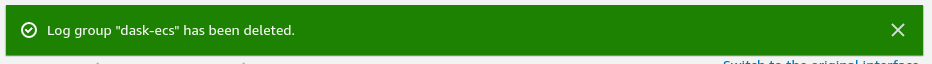

In [ ]:
cluster = FargateCluster()

In [ ]:
cluster

In [ ]:
cluster.status

In [ ]:
cluster.scheduler.address

In [ ]:
cluster.dashboard_link

In [ ]:
cluster.close()